# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 07.06.2024**

**Мягкий дедлайн: 23.06.2024 23:59 MSK**

**Жёсткий дедлайн: 23.06.2024 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


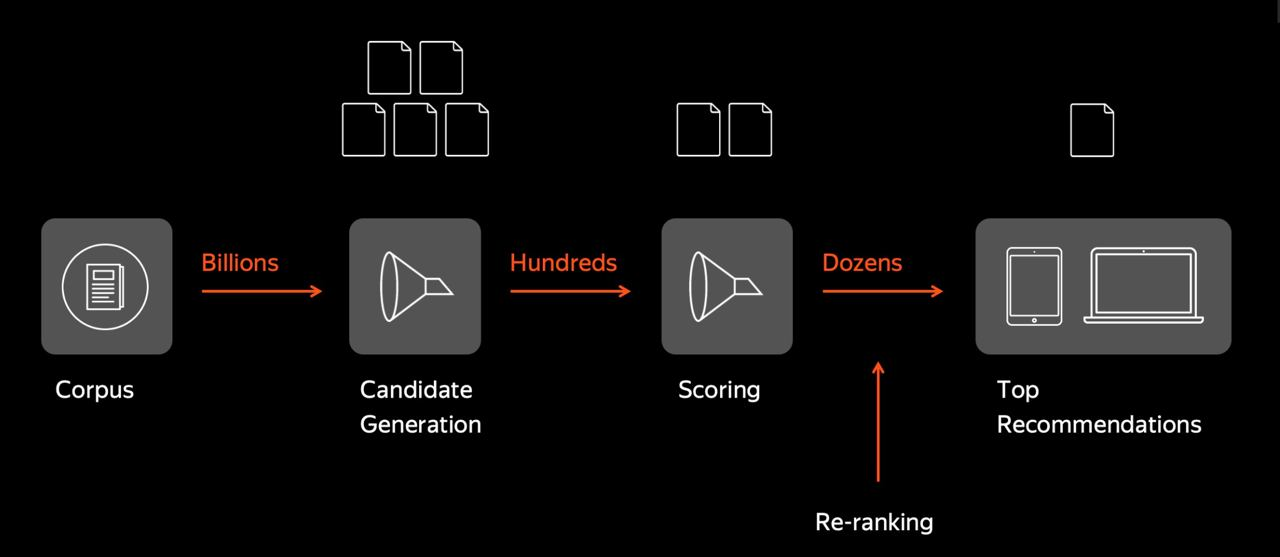

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def apk(relevant: List[int], predicted: List[int], k: int) -> float:
    if len(predicted) > k:
        predicted = predicted[:k]
        
    score = 0
    num_hits = 0

    for i, p in enumerate(predicted):
        if p in relevant:
            num_hits += 1
            score += num_hits / (i + 1)

    return score / min(len(relevant), k)

def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    ap_list = [apk(r, p, k) for r, p in zip(relevant, predicted)]
    return np.mean(ap_list)

In [5]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [6]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [7]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [8]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [9]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [10]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [13]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [14]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        # apply recommend along every user
        # remove train (listened items) items

        recommendation_matrix = np.zeros((self.n_users, self.n_items), dtype=int)
        for uid in range(self.n_users):
            user_recommendations = self.recommend(uid)
            recommendation_matrix[uid] = np.squeeze(user_recommendations)
        test_preds[:self.n_users] = self.remove_train_items(recommendation_matrix, k).tolist()
        
        return test_preds

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).
* $i$ - номер трека

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [15]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    user_vector = user_vector.reshape(1, -1)
    and_matrix = np.logical_and(ratings, user_vector)
    or_matrix = np.logical_or(ratings, user_vector)

    distance_vector = np.sum(and_matrix, axis=1) / np.sum(or_matrix, axis=1)
    distance_vector[distance_vector == 1.] = 0
    
    return distance_vector

In [16]:
rt = np.array( [[1, 0, 0, 1, 0, 1, 0], [1, 1, 0, 1, 0, 1, 0], [1, 1, 1, 0, 0, 1, 0]] )
uv = np.array( [1, 1, 1, 0, 0, 1, 0] )

jaccard(rt, uv)

array([0.4, 0.6, 0. ])

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [17]:
class User2User(BaseModel):
    def __init__(self, ratings, alpha=0.02):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = alpha

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        distance = self.similarity_func(self.R, user_vector)
        similar_objects = np.argwhere(distance >= self.alpha) # similar users in our case
        return similar_objects

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        similar_users_index = np.squeeze(self.similarity(self.R[uid]))
        similar_users_matrix = self.R[similar_users_index]
        similar_users_distance = self.similarity_func(similar_users_matrix, self.R[uid])
        
        if similar_users_matrix.ndim == 1:
            recommended_tracks = (similar_users_distance * similar_users_matrix) / (np.abs(similar_users_distance).sum() + 1e-4)
        else:
            weighted_ratings = np.dot(similar_users_distance.T, similar_users_matrix)
            sum_similarities = np.abs(similar_users_distance).sum() + 1e-4
            recommended_tracks = weighted_ratings / sum_similarities
    
        recommended_tracks = np.argsort(-recommended_tracks)
        
        return recommended_tracks

In [62]:
model = User2User(train_ratings)

In [59]:
pred_recs = model.get_test_recommendations(15)

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [60]:
filtered_pred_recs = [pred_recs[i] for i in range(len(pred_recs)) if i in test_users]

In [133]:
len(filtered_pred_recs)

235

In [61]:
mapk(test_relevant, filtered_pred_recs, 15)

0.001291581546900696

In [135]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
test_alpha = np.arange(0.0001, 0.0501, 0.0025)
test_results =[]
for alpha in test_alpha:
    model = User2User(train_ratings, alpha=alpha)
    predict = model.get_test_recommendations(15)
    filtered_pred_recs = [predict[i] for i in range(len(predict)) if i in test_users]
    test_results.append( mapk(test_relevant, filtered_pred_recs, 15) )

In [136]:
data = pd.DataFrame(data={'alpha':test_alpha, 'MAP@15':test_results})

**Метрика в зависимости от alpha**


<Axes: xlabel='alpha', ylabel='MAP@15'>

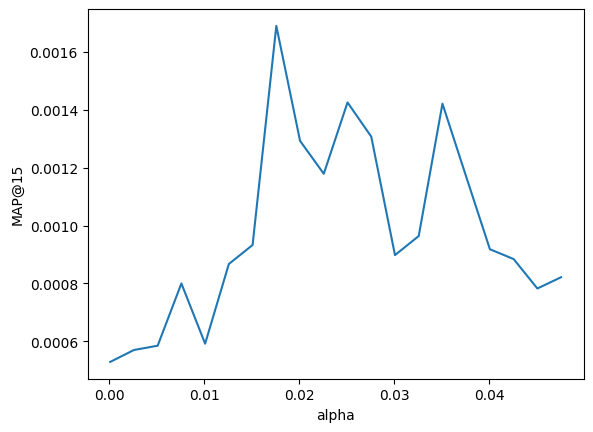

In [137]:
sns.lineplot(data, x='alpha', y='MAP@15')

In [138]:
test_k = [5, 10, 15, 20, 25, 30]
test_results_k =[]
model = User2User(train_ratings)
for k in test_k:
    predict = model.get_test_recommendations(k)
    filtered_pred_recs = [predict[i] for i in range(len(predict)) if i in test_users]
    test_results_k.append( mapk(test_relevant, filtered_pred_recs, k) )

<Axes: xlabel='k', ylabel='MAP@k'>

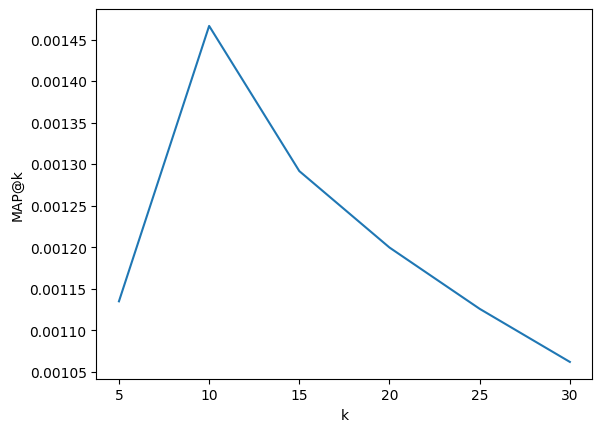

In [139]:
data = pd.DataFrame(data={'k':test_k, 'MAP@k':test_results_k})
sns.lineplot(data, x='k', y='MAP@k')

**Посмотрим на точность при рекомендации топовых треков**

In [140]:
b = model.R
top_tracs = np.argsort(-np.apply_along_axis(np.sum, 0, b))

In [141]:
arr = [5, 10, 15, 20, 25, 30, 35, 40, 45]
test_results_top = []
for size in arr:
    arr_mask = []
    for i in range(235):
        arr_mask.append(top_tracs[:size])
    test_results_top.append( mapk(test_relevant, arr_mask, size) )

In [142]:
data = pd.DataFrame(data={'num_tops':arr, 'MAP@num_top':test_results_top})

<Axes: xlabel='num_tops', ylabel='MAP@num_top'>

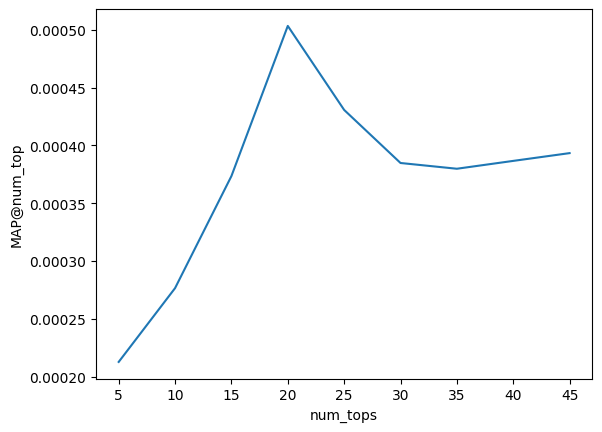

In [143]:
sns.lineplot(data, x='num_tops', y='MAP@num_top')

**Посмотрим теперь на просто рандомные**

In [147]:
arr = [5, 10, 15, 20, 25, 30, 35, 40, 45]
test_results_rand = []
for size in arr:
    matrix = np.random.randint(0, 67313, size=(235, size))
    test_results_rand.append( mapk(test_relevant, matrix, size) )

<Axes: xlabel='num_rand', ylabel='MAP@num_rand'>

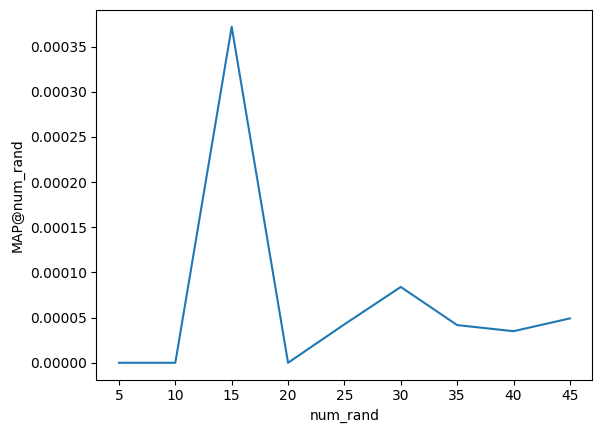

In [148]:
data = pd.DataFrame(data={'num_rand':arr, 'MAP@num_rand':test_results_rand})
sns.lineplot(data, x='num_rand', y='MAP@num_rand')

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [26]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [27]:
user_id = np.random.randint(0, model.n_users)

In [28]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
5,Rock That Body,['Black Eyed Peas']
7,I Gotta Feeling,['Black Eyed Peas']
62,War,['Edwin Starr']
164,My Favourite Game,['The Cardigans']
177,Paper Planes,['M.I.A.']
209,I Got You (I Feel Good),['James Brown']
210,Born To Be Wild,['Steppenwolf']
211,It Feels So Good,['Sonique']
234,Wind Of Change,['Scorpions']
269,Scars,['Papa Roach']


In [29]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
6376,"You're Gonna Go Far, Kid",['The Offspring']
6745,Chop Suey!,['System of A Down']
45208,Беспечный ангел,['Ария']
40209,Выхода нет,['Сплин']
7780,ИСКАЛА,['Земфира']
8263,Shape Of My Heart,['Sting']
1666,Faint,['Linkin Park']
3822,Listen To Your Heart,['Roxette']
933,Sonne,['Rammstein']
938,Ich Will,['Rammstein']


In [31]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
57396,Один человек,"['Пётр Вахрудонов', 'Василий Уриевский']"
58123,Богатыри,['Игорь Растеряев']
58124,Комбайнёры,['Игорь Растеряев']
58211,Молодой,['Игорь Растеряев']
58245,Атака мертвецов,['Radio Tapok']
58368,А мы не ангелы,['Skrizhali']
58566,Любит наш народ,['Ленинград']
58595,Улетай на крыльях ветра (акапелла),['Евгения Сотникова']
58655,Свобода,"['Сергей Шнуров', 'Кипелов']"
58913,Ночные ведьмы,['Radio Tapok']


### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

Ответ:

$$
p_u \larr p_u - \eta ( \sum_{i \in I}(\langle p_u, q_i \rangle - r_{ui})q_i + \lambda p_u) 
$$
$$
q_i \larr q_i - \eta ( \sum_{u \in U}(\langle p_u, q_i \rangle - r_{ui})p_u + \lambda q_i) 
$$

Где $I$ - Items, с которыми взаимодействовал данный user, а $U$ - Users, которые взаимодействовали с данным item 

Теоретически можно считать градиент по одному экземляру из $(u, i)$

$$
p_u \larr p_u - \eta ( (\langle p_u, q_i \rangle - r_{ui})q_i + \lambda p_u) 
$$
$$
q_i \larr q_i - \eta ( (\langle p_u, q_i \rangle - r_{ui})p_u + \lambda q_i) 
$$

Чуть проще будет, если заменить $ (\langle p_u, q_i \rangle - r_{ui}) $ на $e$

$$
p_u \larr p_u - \eta ( e \cdot q_i + \lambda p_u) 
$$
$$
q_i \larr q_i - \eta ( e \cdot p_u + \lambda q_i) 
$$

**ALS:**

Ответ:

$$
p_u = (Q^T \Lambda_u Q + \lambda I)^{-1} Q^T \Lambda_u r_u
$$
$$
q_i = (P^T \Lambda_i P + \lambda I)^{-1} P^T \Lambda_i r_i
$$

$\Lambda_u$ - диагональная матрица, в которой элемент $\lambda_{ii} = 1 | \exists r_{ui}$ 


In [18]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd', lr=0.0003, lamb=0.01):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        # self.P = np.ones(shape=(self.n_users, dim)) + 0.1 * np.random.normal(size=(self.n_users, dim))
        # self.Q = np.ones(shape=(self.n_items, dim)) + 0.1 * np.random.normal(size=(self.n_items, dim))

        self.lr = lr
        self.lamb = lamb

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            
            if self.mode == 'sgd':
                P_new = (self.P).copy()
                Q_new = (self.Q).copy()
                    
                for i in range(P_new.shape[0]):
                    non_zero_items = np.argwhere(self.R[i] != 0.).flatten()
                    if len(non_zero_items) > 0:
                        for item in non_zero_items:
                            error = np.dot(P_new[i], Q_new[item]) - self.R[i, item]
                            P_new[i] -= self.lr * (error * self.Q[item] + self.lamb * self.P[i])
                            Q_new[item] -= self.lr * (error * self.P[i] + self.lamb * self.Q[item])
                self.P = P_new
                self.Q = Q_new

            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                for u in range(self.P.shape[0]):
                    non_zero_items = np.argwhere(self.R[u] != 0.).flatten()
                    if len(non_zero_items) > 0:
                        Lambda_u = np.diag([1 if self.R[u, j] != 0 else 0 for j in non_zero_items])
                        Q_u = self.Q[non_zero_items]
                        A = Q_u.T @ Lambda_u @ Q_u + self.lamb * np.eye(self.dim)
                        V = Q_u.T @ Lambda_u @ self.R[u, non_zero_items]
                        self.P[u] = np.linalg.solve(A, V)

                for i in range(self.Q.shape[0]):
                    non_zero_users = np.argwhere(self.R[:, i] != 0.).flatten()
                    if len(non_zero_users) > 0:
                        Lambda_i = np.diag([1 if self.R[j, i] != 0 else 0 for j in non_zero_users])
                        P_i = self.P[non_zero_users]
                        A = P_i.T @ Lambda_i @ P_i + self.lamb * np.eye(self.dim)
                        V = P_i.T @ Lambda_i @ self.R[non_zero_users, i]
                        self.Q[i] = np.linalg.solve(A, V)

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**User2User top score was 0.0016**

In [28]:
model_sgd = LatentFactorModel(train_ratings)

In [29]:
model_sgd.fit(num_iters=13)

  0%|          | 0/13 [00:00<?, ?it/s]

In [30]:
predict = model_sgd.get_test_recommendations(15)
filtered_pred_recs = [predict[i] for i in range(len(predict)) if i in test_users]
mapk(test_relevant, filtered_pred_recs, 15)

0.00011820330969267139

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [88]:
predict_als = LatentFactorModel(train_ratings, mode='als', dim=92)
predict_als.fit(4)

  0%|          | 0/4 [00:00<?, ?it/s]

In [90]:
predict = predict_als.get_test_recommendations(15)
filtered_pred_recs = [predict[i] for i in range(len(predict)) if i in test_users]
mapk(test_relevant, filtered_pred_recs, 15)

0.0015131149386468535

In [257]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
# Работает очень нестабильно, ждать каждый раз по 10 минут для этого конечно грустно

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [91]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = predict_als.Q @ predict_als.Q[example_trackId]
preds = preds / np.sqrt((predict_als.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [92]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(predict_als.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.722202
5570,Моё сердце,['Сплин'],0.679718
9449,Это всё…,['ДДТ'],0.643124
16637,Zodiac,['Zodiac'],0.627986
5153,Stormbringer,['Deep Purple'],0.627986
9689,Bicycle Race,['Queen'],0.627986
58063,UNO,['Little Big'],0.623762
16224,Пока горит свеча,['Машина времени'],0.620918
14871,Никто не услышит (Ой-йо),['ЧайФ'],0.604575


**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

In [40]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als', 'ials']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01
        self.alpha = 40  # Confidence weight parameter for IALS

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            
            if self.mode == 'sgd':
                P_new = (self.P).copy()
                Q_new = (self.Q).copy()
                    
                for i in range(P_new.shape[0]):
                    non_zero_items = np.argwhere(self.R[i] != 0.).flatten()
                    if len(non_zero_items) > 0:
                        for item in non_zero_items:
                            error = np.dot(P_new[i], Q_new[item]) - self.R[i, item]
                            P_new[i] -= self.lr * (error * self.Q[item] + self.lamb * self.P[i])
                            Q_new[item] -= self.lr * (error * self.P[i] + self.lamb * self.Q[item])
                self.P = P_new
                self.Q = Q_new

            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                for u in range(self.P.shape[0]):
                    non_zero_items = np.argwhere(self.R[u] != 0.).flatten()
                    if len(non_zero_items) > 0:
                        Lambda_u = np.diag([1 if self.R[u, j] != 0 else 0 for j in non_zero_items])
                        Q_u = self.Q[non_zero_items]
                        A = Q_u.T @ Lambda_u @ Q_u + self.lamb * np.eye(self.dim)
                        V = Q_u.T @ Lambda_u @ self.R[u, non_zero_items]
                        self.P[u] = np.linalg.solve(A, V)

                for i in range(self.Q.shape[0]):
                    non_zero_users = np.argwhere(self.R[:, i] != 0.).flatten()
                    if len(non_zero_users) > 0:
                        Lambda_i = np.diag([1 if self.R[j, i] != 0 else 0 for j in non_zero_users])
                        P_i = self.P[non_zero_users]
                        A = P_i.T @ Lambda_i @ P_i + self.lamb * np.eye(self.dim)
                        V = P_i.T @ Lambda_i @ self.R[non_zero_users, i]
                        self.Q[i] = np.linalg.solve(A, V)
            
            elif self.mode == 'ials':
                for u in range(self.P.shape[0]):
                    non_zero_items = np.argwhere(self.R[u] != 0.).flatten()
                    if len(non_zero_items) > 0:
                        C_u = np.diag(1 + self.alpha * self.R[u, non_zero_items])
                        Q_u = self.Q[non_zero_items]
                        A = Q_u.T @ C_u @ Q_u + self.lamb * np.eye(self.dim)
                        V = Q_u.T @ (C_u @ self.R[u, non_zero_items])
                        self.P[u] = np.linalg.solve(A, V)

                for i in range(self.Q.shape[0]):
                    non_zero_users = np.argwhere(self.R[:, i] != 0.).flatten()
                    if len(non_zero_users) > 0:
                        C_i = np.diag(1 + self.alpha * self.R[non_zero_users, i])
                        P_i = self.P[non_zero_users]
                        A = P_i.T @ C_i @ P_i + self.lamb * np.eye(self.dim)
                        V = P_i.T @ (C_i @ self.R[non_zero_users, i])
                        self.Q[i] = np.linalg.solve(A, V)

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T
        return np.argsort(pred_rating)[::-1]

In [41]:
model_ials = LatentFactorModel(train_ratings, mode='ials', dim=86)
model_ials.fit(num_iters=4)
predict = model_ials.get_test_recommendations(15)
filtered_pred_recs = [predict[i] for i in range(len(predict)) if i in test_users]
mapk(test_relevant, filtered_pred_recs, 15)

  0%|          | 0/4 [00:00<?, ?it/s]

0.000723482191567298

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [93]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
# Возьму топ 100 от ALS 
ALS_top = predict_als.get_test_recommendations(100)

In [64]:
User2User_top = model.get_test_recommendations(100)

**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [94]:
recomended_tracks = []
for i in range(len(User2User_top)):
    temp_set = list(set( User2User_top[i] + ALS_top[i] ))
    recomended_tracks.append(temp_set)

In [135]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

df = pd.DataFrame({
    'User_Id': list(range(241)),
    'Recommended_Tracks': recomended_tracks
})
df = df.explode('Recommended_Tracks').reset_index(drop=True)
df

,User_Id,Recommended_Tracks
0,0,28672
1,0,14853
2,0,17926
3,0,30213
4,0,48645
...,...,...
45545,240,39923
45546,240,15346
45547,240,19452
45548,240,50173


In [136]:
from sklearn.metrics.pairwise import cosine_distances

In [137]:
def cosine_distance(user_id, track_id):
        user_embedding = predict_als.P[user_id]
        track_embedding = predict_als.Q[track_id]
        return cosine_distances([user_embedding], [track_embedding])[0][0]

def calculate_jaccard_similarity(idd_matrix, target_user_id):
    return np.mean(jaccard(idd_matrix, idd_matrix[target_user_id]))

In [138]:
df['Cosine_distance'] = df.apply(lambda row: cosine_distance(row['User_Id'], row['Recommended_Tracks']), axis=1)

In [112]:
from joblib import Parallel, delayed
def parallel_jaccard(target_user_id):
    idd_matrix = model.R
    return calculate_jaccard_similarity(idd_matrix, target_user_id)

In [139]:
idd_matrix = []
for i in range(241):
    idd_matrix.append(np.mean(jaccard(model.R, model.R[i])))

In [140]:
df_index = pd.DataFrame({
    'User_Id': list(range(241)),
    'Mean_jaccard': idd_matrix
})

In [114]:
df['Jaccard_similarity'] = Parallel(n_jobs=6)(
    delayed(parallel_jaccard)(user_id) for user_id in df['User_Id']
)

KeyboardInterrupt: 

In [108]:
df['Jaccard_similarity'] = df['User_Id'].apply(lambda user_id: calculate_jaccard_similarity(idd_matrix, user_id))

KeyboardInterrupt: 

In [141]:
df = pd.merge(df, df_index, on='User_Id', how='left')
df

,User_Id,Recommended_Tracks,Cosine_distance,Mean_jaccard
0,0,28672,0.825854,0.003435
1,0,14853,0.917136,0.003435
2,0,17926,1.025172,0.003435
3,0,30213,0.834214,0.003435
4,0,48645,0.829020,0.003435
...,...,...,...,...
45545,240,39923,0.855461,0.004039
45546,240,15346,0.891341,0.004039
45547,240,19452,0.871970,0.004039
45548,240,50173,0.953232,0.004039


In [129]:
num_of_listened = []
for i in range(241):
    num_of_listened.append(np.sum(model.R[i]))

In [142]:
df_count = pd.DataFrame({
    'User_Id': list(range(241)),
    'Num_tracks_listened': num_of_listened
})

In [144]:
df = pd.merge(df, df_count, on='User_Id', how='left')
df

,User_Id,Recommended_Tracks,Cosine_distance,Mean_jaccard,Num_tracks_listened
0,0,28672,0.825854,0.003435,206.0
1,0,14853,0.917136,0.003435,206.0
2,0,17926,1.025172,0.003435,206.0
3,0,30213,0.834214,0.003435,206.0
4,0,48645,0.829020,0.003435,206.0
...,...,...,...,...,...
45545,240,39923,0.855461,0.004039,1668.0
45546,240,15346,0.891341,0.004039,1668.0
45547,240,19452,0.871970,0.004039,1668.0
45548,240,50173,0.953232,0.004039,1668.0


In [147]:
frac_of_listened_track = []
for i in range(model.R.shape[1]):
    frac_of_listened_track.append( np.sum(model.R[:,i])/241 )

In [153]:
df_count = pd.DataFrame({
    'Recommended_Tracks': list(range(model.R.shape[1])),
    'Frac_listened': frac_of_listened_track
})

In [155]:
df = pd.merge(df, df_count, on='Recommended_Tracks', how='left')
df

,User_Id,Recommended_Tracks,Cosine_distance,Mean_jaccard,Num_tracks_listened,Frac_listened
0,0,28672,0.825854,0.003435,206.0,0.029046
1,0,14853,0.917136,0.003435,206.0,0.012448
2,0,17926,1.025172,0.003435,206.0,0.045643
3,0,30213,0.834214,0.003435,206.0,0.037344
4,0,48645,0.829020,0.003435,206.0,0.029046
...,...,...,...,...,...,...
45545,240,39923,0.855461,0.004039,1668.0,0.091286
45546,240,15346,0.891341,0.004039,1668.0,0.136929
45547,240,19452,0.871970,0.004039,1668.0,0.091286
45548,240,50173,0.953232,0.004039,1668.0,0.020747


Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ). 

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [ ]:
import catboost

# group_id == user_id here
train_pool = catboost.Pool(X_train, y_train, group_id=train_group_id)
test_pool = catboost.Pool(X_test, y_test, group_id=test_group_id)

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪